Q4. ​Dataset​: Labeled Faces in the Wild, [​Link​ for dataset] ​[50 Marks + 10 Marks Bonus]
You need to perform binary classification for a person wearing ‘sunglasses’/’Eyeglasses’ in the dataset. There are number of attributes present for LFW dataset(please refer the link for details about the attributes labeling).[​Link​ for attributes]
● Separate the dataset into 2 files. 65% and 35% of the total dataset.
● For 65% dataset, perform binary classification for the person wearing ‘sunglasses’ /’Eyeglasses’
or not. [​Note​: In the dataset, eyeglasses and sunglasses are treated as different entities, you need
to consider them as single entity]
● UseDenseLayerModel:[128--128--128--64--1]
 
● Keep the loss function as the “mean square error”.
● Do you think there is any kind of bias in the system? Evaluate the system using 3 different
evaluation metrics to see if there is any bias or not. [10 Marks]
● Come up with a new evaluation metric to detect if there is a bias in the system.
[ Bonus 10 Marks]
● If you observed any bias in the system, mitigate the bias by: [30 Marks]
○ DATA method (Training using more data): You may use more data for training from that
35% data. Report the accuracy after mitigation and compare it with previous
classification results.
○ ALGORITHMIC method: Alter loss function to incorporate more challenges. Use a
multi-tasking approach to achieve your aim.Report the accuracy after mitigation and compare it with previous classification results.

dataset link: http://vis-www.cs.umass.edu/lfw/

attributes link: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt

In [ ]:

import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm

# Google Drive access
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/LFW
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/LFW
/content/gdrive/My Drive/LFW


In [ ]:
# Dumping files to drive
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2020-12-29 07:00:43--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2020-12-29 07:00:44--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt.7’

lfw_attributes.txt. 100%[===================>]  14.19M  15.3MB/s    in 0.9s    

2020-12-29 07:00:45 (15.3 MB/s) - ‘lfw_attributes.txt.7’ saved [14879205/14879205]

--2020-12-29 07:00:45--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www

In [ ]:
# File handlers
attributes = "lfw_attributes.txt"
images = "lfw.tgz"

In [ ]:
# ref: https://colab.research.google.com/github/MalihaUCF/Autoencoders/blob/master/Autoencoder_PCA1.ipynb#scrollTo=C0miIeXh9dy1&line=28&uniqifier=1

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=True,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(attributes, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(images) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


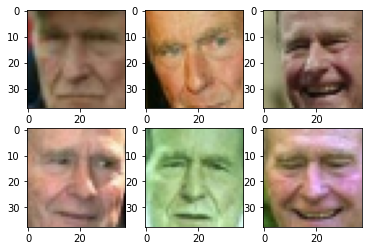

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
#from lfw_dataset import load_lfw_dataset
import tensorflow as tf
import keras, keras.layers as L

# Loading and normalizing [Might take some time]
X, attributes = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0
img_shape = X.shape[1:]
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
# Checking out some images
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])
print("X shape:",X.shape)
print("attr shape:",attributes.shape)

In [ ]:
# lets divide the dataset into 65% and 35%

In [ ]:
X_65 = np.round(0.65*len(X))

In [ ]:
X_65

8543.0

In [ ]:
attributes.Eyeglasses.iloc[0]
attributes['Eyeglasses_Sunglasses'] = 0
for i in range(len(attributes)):
  # to consider Eyeglasses and Sunglases as same quantity, let us take average of both and add it to the dataframe
  if(np.sign(attributes.Eyeglasses.iloc[i])==1 or np.sign(attributes.Sunglasses.iloc[i])==1):
    attributes['Eyeglasses_Sunglasses'].iloc[i] = 1
  else:
    attributes['Eyeglasses_Sunglasses'].iloc[i] = 0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
attributes.head()

Male    Asian  ... Wearing Necklace Eyeglasses_Sunglasses
0 -0.602662 -0.83636  ...        -0.882286                     0
1  0.505597 -1.91405  ...         -0.80375                     1
2    1.4038 -1.39616  ...        -0.163028                     0
3  0.929768 -1.75116  ...        -0.601105                     1
4   1.38212 -1.83819  ...        -0.308988                     1

[5 rows x 74 columns]

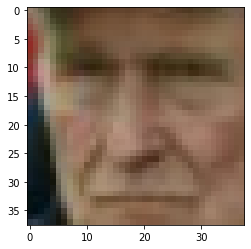

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[0])

Xtrain and Ytrain

Xtest and Ytest

# Start from here

In [52]:
X_train_65 = X[0:8543]
len(X_train_65)
np.round(0.80*8543)
X_train_65_80 = X_train_65[0:6834]
X_test_65_80 = X_train_65[6834:8543]

print(len(X_train_65_80))
print(len(X_test_65_80))

Xtrain = X_train_65_80
Xtest = X_test_65_80
Ydata = np.array(attributes.Eyeglasses_Sunglasses)
print(len(Ydata))
print(Ydata)
Y_65 = Ydata[0:8543]
Y_train_65_80 = Y_65[0:6834] # Taking 80% data
Y_test_65_80 = Y_65[6834:8543]
print(len(Y_train_65_80))
print(len(Y_test_65_80))
Ytrain = Y_train_65_80
Ytest = Y_test_65_80


6834
1709
13143
[0 1 0 ... 0 0 0]
6834
1709


In [53]:
Xtrain = Xtrain[:,:,:,0]
Xtest = Xtest[:,:,:,0]
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(6834, 38, 38)
(6834,)
(1709, 38, 38)
(1709,)


In [54]:
print(type(Xtrain))
print(type(Ytrain))
print(type(Xtest))
print(type(Ytest))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [55]:
Xtrain = Xtrain.reshape(6834,38*38)
Xtest = Xtest.reshape(1709,38*38)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(6834, 1444)
(6834,)
(1709, 1444)
(1709,)


In [56]:
from skimage import data
from skimage.color import rgb2gray
Xtrain_rgb2grey = rgb2gray(Xtrain)
Xtest_rgb2grey = rgb2gray(Xtest)
print(Xtrain_rgb2grey.shape)
print(Ytrain.shape)
print(Xtest_rgb2grey.shape)
print(Ytest.shape)

(6834, 1444)
(6834,)
(1709, 1444)
(1709,)


In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models

ann = models.Sequential([
        # layers.Flatten(input_shape=(1444)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')    
    ])

ann.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])

ann.fit(Xtrain, Ytrain, epochs=20)

Epoch 1/20
214/214 [==============================] - 1s 2ms/step - loss: 0.1767 - accuracy: 0.7638
Epoch 2/20
214/214 [==============================] - 1s 2ms/step - loss: 0.1642 - accuracy: 0.7902
Epoch 3/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.7908
Epoch 4/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.7948
Epoch 5/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1555 - accuracy: 0.7966
Epoch 6/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.7929
Epoch 7/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1529 - accuracy: 0.7931
Epoch 8/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1533 - accuracy: 0.7888
Epoch 9/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.7932
Epoch 10/20
214/214 [==============================] - 0s 2ms/step - loss: 0.1443 - accuracy: 0.8009

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      1430
           1       0.80      0.06      0.11       279

    accuracy                           0.84      1709
   macro avg       0.82      0.53      0.51      1709
weighted avg       0.84      0.84      0.78      1709

-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
Confusion Matrix: 
 [[1426    4]
 [ 263   16]]
-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
Accuracy Score: 
 0.8437682855471036
-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
along x axis - true, along y axis - predicted


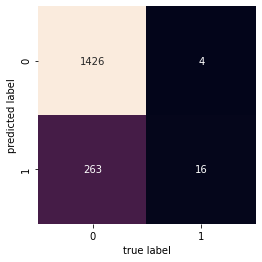

In [59]:
classes = ['0','1']
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score
import numpy as np
Ypred = ann.predict(Xtest)

for i in range(len(Ypred)):
  if(Ypred[i]>0.5):
    Ypred_classes[i]=1
  else:
    Ypred_classes[i]=0

print("Classification Report: \n", classification_report(Ytest, Ypred_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("Confusion Matrix: \n", confusion_matrix(Ytest, Ypred_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("Accuracy Score: \n", accuracy_score(Ytest, Ypred_classes))
print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/")
print("along x axis - true, along y axis - predicted")

import seaborn as sns

matrix = confusion_matrix(Ytest, Ypred_classes)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');